In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
# import seaborn as sns

os.getcwd()

'/home/mgteus/workspace/neuro/transformers_andrej'

In [2]:
from attention_model import Head, get_batch1d, get_batch2d, RMSELoss, MultiHeadAttention

In [3]:
from torchtune.modules import RotaryPositionalEmbeddings

uintx feature requires torch 2.3+, please upgrade pytorch


In [ ]:
CONTEXT_LEN = 64
BATCH_SIZE = 512
DROPOUT = 0.1
LEARNING_RATE = 1e-3
NUM_HEADS = 2
NUM_EPOCHS = 1e5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
DEVICE, NUM_EPOCHS

('cpu', 100000.0)

In [6]:
# model = Head(context_len=CONTEXT_LEN, batch_size=BATCH_SIZE, dropout=DROPOUT)
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
1e-3

In [7]:
# model = Head(context_len=CONTEXT_LEN, batch_size=BATCH_SIZE, dropout=DROPOUT)
model = MultiHeadAttention(
                num_heads = NUM_HEADS
            , context_len = CONTEXT_LEN
            , batch_size = BATCH_SIZE
            , dropout = DROPOUT
            ,head_output_dim=2)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [8]:
xb, yb = get_batch2d(context_len=CONTEXT_LEN, batch_size=BATCH_SIZE, split='train', device=DEVICE)

In [9]:
head = Head(context_len=CONTEXT_LEN, batch_size=4, dropout=0, output_dim=2)

In [10]:
head(xb).shape

torch.Size([512, 64, 2])

In [11]:
loss_list = []

In [12]:
for epoch in range(int(NUM_EPOCHS)):
    xb, yb = get_batch2d(context_len=CONTEXT_LEN, batch_size=BATCH_SIZE, split='train', device=DEVICE)
    optimizer.zero_grad(set_to_none=True)
    predictions = model(xb)
    predictions = predictions.to(DEVICE)
    loss = RMSELoss(predictions, yb)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.cpu().detach().numpy())
    if epoch%1000==0:
        print(f"iter. {epoch} - loss = {loss.item():4f}")


iter. 0 - loss = 0.769751
iter. 1000 - loss = 0.735852
iter. 2000 - loss = 0.695159
iter. 3000 - loss = 0.653543
iter. 4000 - loss = 0.617537
iter. 5000 - loss = 0.604402
iter. 6000 - loss = 0.575308
iter. 7000 - loss = 0.540970


: 

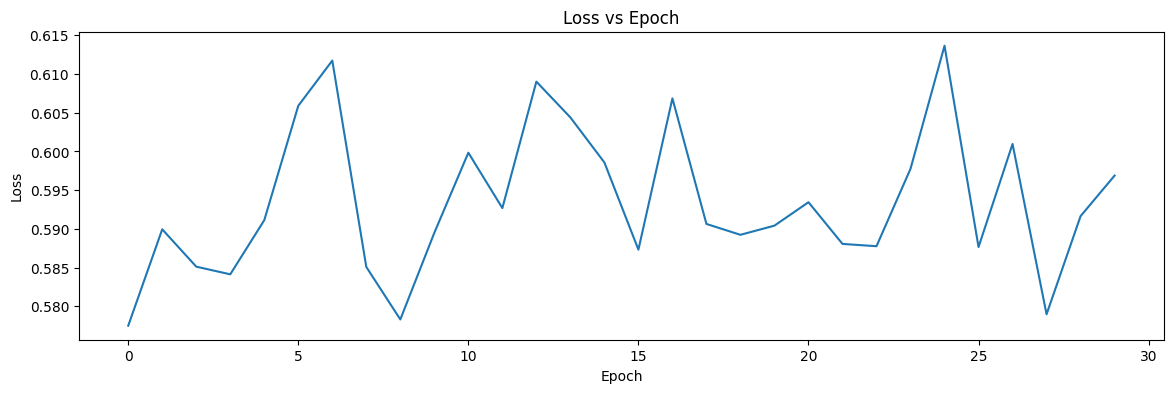

In [29]:
fig, ax = plt.subplots(figsize=(14,4))
plt.plot(loss_list)
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [45]:
np.std(loss_list)

0.15685869990256046

In [33]:
np_predictions = predictions.cpu().detach().numpy()

In [34]:
np_true = yb.cpu().detach().numpy()
np_context = xb.cpu().detach().numpy()

In [24]:
# for i in range(BATCH_SIZE):
#     plt.title(f'Plot Batch {i}')
#     plt.scatter(np_predictions[i, -1, 0], np_predictions[i, -1, 1], label='predictions', c='r')
#     plt.scatter(np_context[i, :,0], np_context[i, :, 1], label='Context', c=[color for color in range(60)], alpha=0.4, marker='^')
#     plt.scatter(np_true[i, -1, 0], np_true[i, -1, 1], label='True', c='k', marker='^')
#     plt.legend()
#     plt.colorbar(label='context steps')
#     # plt.xlim(0, 1)
#     # plt.ylim(0, 1)
#     plt.show()

In [13]:
print(model)

Head(
  (pos_to_enc_layer): Linear(in_features=2, out_features=2, bias=True)
  (enc_layer): Linear(in_features=2, out_features=1, bias=True)
  (output_layer): Linear(in_features=30, out_features=2, bias=True)
  (key): Linear(in_features=2, out_features=30, bias=True)
  (query): Linear(in_features=2, out_features=30, bias=True)
  (values): Linear(in_features=2, out_features=30, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [14]:
np_context[1, :, :]

array([[6.67184293e-01, 2.28796124e-01],
       [6.83304250e-01, 2.25809067e-01],
       [6.98330462e-01, 2.25448474e-01],
       [7.14234829e-01, 2.24773765e-01],
       [7.26846516e-01, 2.22726643e-01],
       [7.38823652e-01, 2.10158736e-01],
       [7.53234565e-01, 2.02657163e-01],
       [7.66567945e-01, 1.97783709e-01],
       [7.72364914e-01, 1.92914262e-01],
       [7.76286662e-01, 1.88179374e-01],
       [7.79312909e-01, 1.83719724e-01],
       [7.83761859e-01, 1.79553077e-01],
       [7.84764588e-01, 1.77794084e-01],
       [7.86282301e-01, 1.73830315e-01],
       [7.87906706e-01, 1.69042006e-01],
       [7.90079653e-01, 1.61052302e-01],
       [7.87650526e-01, 1.54013067e-01],
       [7.85222471e-01, 1.42920658e-01],
       [7.82741070e-01, 1.36050567e-01],
       [7.76128769e-01, 1.27371609e-01],
       [7.66335547e-01, 1.14834987e-01],
       [7.58846760e-01, 1.03228435e-01],
       [7.43753731e-01, 9.03680697e-02],
       [7.32177854e-01, 6.81027919e-02],
       [7.229100

In [15]:
np.mean(np_context[1, :, :], axis=0)

array([0.7464002 , 0.13981335], dtype=float32)

In [18]:
xb[1, :1, :].shape, xb.shape

(torch.Size([1, 2]), torch.Size([16, 30, 2]))

In [19]:
xb[1,:30, :].shape

torch.Size([30, 2])

In [20]:
print('input', xb[1,1:11, :],)
print('media', np.mean(np_context[1,:11, :], axis=0))
print('predict', model(xb[:1,:30, :]))
print('true', yb[1, 10:11, :])

input tensor([[0.6833, 0.2258],
        [0.6983, 0.2254],
        [0.7142, 0.2248],
        [0.7268, 0.2227],
        [0.7388, 0.2102],
        [0.7532, 0.2027],
        [0.7666, 0.1978],
        [0.7724, 0.1929],
        [0.7763, 0.1882],
        [0.7793, 0.1837]])
media [0.73422647 0.20936064]
predict tensor([[[0.8220, 0.1418],
         [0.8271, 0.1460],
         [0.8327, 0.1499],
         [0.8380, 0.1552],
         [0.8455, 0.1589],
         [0.8542, 0.1620],
         [0.8630, 0.1647],
         [0.8728, 0.1668],
         [0.8821, 0.1690],
         [0.8906, 0.1706],
         [0.8985, 0.1713],
         [0.9059, 0.1720],
         [0.9121, 0.1730],
         [0.9178, 0.1739],
         [0.9231, 0.1748],
         [0.9279, 0.1755],
         [0.9322, 0.1762],
         [0.9354, 0.1769],
         [0.9376, 0.1776],
         [0.9393, 0.1782],
         [0.9404, 0.1789],
         [0.9410, 0.1796],
         [0.9412, 0.1803],
         [0.9409, 0.1809],
         [0.9401, 0.1815],
         [0.9391, 0.

In [ ]:
xb[1,:30, :]

In [25]:
model(xb[:1,:30, :])[0][0][0]

tensor(0.8220, grad_fn=<SelectBackward0>)

In [26]:
xb.shape

torch.Size([16, 30, 2])

In [ ]:
model(xb[1,30:32, :])

In [ ]:
model(xb[1,:30, :]).shape

In [ ]:
model(xb[1,0:i, :])

In [ ]:
yb[1,0:i, :]

In [ ]:
model(xb[1,i-1:i, :])[-1]

In [ ]:
np_true[1, i-1:i,0]

In [59]:
i=10

In [67]:
np_context[1,0:i+1, 0]

array([0.6671843 , 0.68330425, 0.69833046, 0.7142348 , 0.7268465 ,
       0.73882365, 0.75323457, 0.76656795, 0.7723649 , 0.77628666,
       0.7793129 ], dtype=float32)

In [68]:
np_true[1, i-1:i,0], np_true[1, i-1:i,1]

(array([0.7793129], dtype=float32), array([0.18371972], dtype=float32))

In [69]:
model(xb[:1,i-1:i, :])[0][0][0], model(xb[:1,i-1:i, :])[0][0][1]

(tensor(0.9400, grad_fn=<SelectBackward0>),
 tensor(0.1796, grad_fn=<SelectBackward0>))

In [70]:
xb[:1,i-1:i, :]

tensor([[[0.9592, 0.1478]]])

In [73]:
for i in range(1, 10):
    print(i, model(xb[:1,i-1:i, :]))

1 tensor([[[0.8220, 0.1418]]], grad_fn=<ViewBackward0>)
2 tensor([[[0.8320, 0.1500]]], grad_fn=<ViewBackward0>)
3 tensor([[[0.8431, 0.1571]]], grad_fn=<ViewBackward0>)
4 tensor([[[0.8520, 0.1693]]], grad_fn=<ViewBackward0>)
5 tensor([[[0.8701, 0.1712]]], grad_fn=<ViewBackward0>)
6 tensor([[[0.8875, 0.1739]]], grad_fn=<ViewBackward0>)
7 tensor([[[0.9014, 0.1761]]], grad_fn=<ViewBackward0>)
8 tensor([[[0.9192, 0.1765]]], grad_fn=<ViewBackward0>)
9 tensor([[[0.9305, 0.1808]]], grad_fn=<ViewBackward0>)


In [71]:
xb[:1,:i, :]

tensor([[[0.8378, 0.1119],
         [0.8481, 0.1200],
         [0.8596, 0.1271],
         [0.8691, 0.1393],
         [0.8877, 0.1408],
         [0.9054, 0.1432],
         [0.9197, 0.1451],
         [0.9378, 0.1451],
         [0.9496, 0.1493],
         [0.9592, 0.1478]]])

In [61]:
xb.shape

torch.Size([16, 30, 2])

In [25]:
# for i in range(1, 30):
#     plt.title(f'Plot Batch 1 | step {i:02d}')
#     plt.scatter(np_context[1,0:i, 0], np_context[1,0:i, 1],  label='Context', c=[color for color in range(len(np_context[1,0:i, 0]))], alpha=0.4, marker='^')
#     plt.scatter(model(xb[:1,i-1:i, :])[0][0][0].item(), model(xb[:1,i-1:i, :])[0][0][1].item(), label='prediction', c='r')
#     plt.scatter(np_true[1, i-1:i,0], np_true[1, i-1:i,1], label='True', c='k', marker='^')
#     plt.legend()
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.colorbar(label='context steps')
#     # plt.xlim(0, 1)
#     # plt.ylim(0, 1)
#     plt.show()

In [ ]:
loss_mean = []
for i in range(1, 31):
    
    loss_mean.append(RMSELoss(model(xb[1,i-1:i, :]), yb[1,i-1:i, :]).detach().numpy())



np.mean(loss_mean)

In [ ]:
np.std(loss_mean)

In [ ]:
np.mean(np_context[1, :, 0]), np.mean(np_context[1, :, 1])

In [ ]:
sns.histplot(np_context[1, :, 0])

In [ ]:
yb[1, :1, :]

In [ ]:
np_predictions[1, 0, :]

In [9]:
key_weight = model.key.weight.detach().numpy()
query_weight = model.query.weight.detach().numpy()
values_weight = model.values.weight.detach().numpy()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

sns.heatmap(key_weight, cmap='viridis', ax=ax[0])
ax[0].set_title('Key Weights')

sns.heatmap(query_weight, cmap='viridis', ax=ax[1])
ax[1].set_title('Query Weights')

sns.heatmap(values_weight, cmap='viridis', ax=ax[2])
ax[2].set_title('Values Weights')
plt.show()